In [310]:
import keras
from keras.datasets import cifar10

In [311]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [448]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [449]:
x_train_birds = np.zeros((5000,32,32,3))
j = 0
k=0
for i in (y_train == 2):
    if(i==True):
        x_train_birds[j] = x_train[k]
        j=j+1
    k=k+1

In [450]:
x_train_birds.shape

(5000, 32, 32, 3)

In [451]:
x_test_birds = np.zeros((1000,32,32,3))
j = 0
k=0
for i in (y_test == 2):
    if(i==True):
        x_test_birds[j] = x_test[k]
        j=j+1
    k=k+1

In [452]:
len(y_test == 2)

10000

In [453]:
x_test_birds.shape

(1000, 32, 32, 3)

In [454]:
x_full = np.concatenate((x_train_birds,x_test_birds))
x_full.shape

(6000, 32, 32, 3)

In [455]:
x_full_linear = np.reshape(np.ravel(x_full), (6144000,3))

In [456]:
print(x_full_linear)

[[ 164.  206.   84.]
 [ 105.  140.   61.]
 [ 118.  148.  101.]
 ..., 
 [ 156.  179.   95.]
 [ 158.  180.   98.]
 [ 157.  179.   98.]]


In [457]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0,n_init = 20).fit(x_full_linear)

In [458]:
distances = kmeans.transform(x_full_linear)

In [459]:
distances

array([[ 111.87250516,  134.43626393,   72.59085431,  199.03332251],
       [  38.34897458,  195.14383872,   91.77004631,  108.32171466],
       [  44.37946763,  155.22201591,   52.05620685,  135.11477335],
       ..., 
       [  85.55194764,  131.06029683,   46.87931363,  176.81867249],
       [  87.95483479,  127.37626502,   44.88275137,  179.7311272 ],
       [  86.58641648,  128.01303414,   44.31550004,  178.40224653]])

In [460]:
len(distances)

6144000

In [461]:
kmeans.cluster_centers_

array([[ 108.97036568,  108.60691289,   82.66458238],
       [ 206.53651167,  211.77549799,  211.39857871],
       [ 156.18468173,  155.51640472,  135.57285659],
       [  49.02965771,   50.01208333,   38.57034319]])

[[108 108  82]
 [206 211 211]
 [156 155 135]
 [ 49  50  38]]


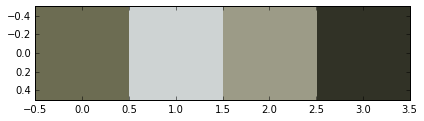

In [462]:
from skimage import io
%matplotlib inline
center_colors = np.uint8(kmeans.cluster_centers_)
print(center_colors)
indices = np.array(range(len(center_colors))).reshape(-1, 4)
io.imshow(center_colors[indices])

In [463]:
pixel_labels = kmeans.labels_

In [464]:
k_coloured_images = []
for i in pixel_labels:
    k_coloured_images.append(np.uint8(kmeans.cluster_centers_[i]))

In [465]:
len(k_coloured_images)

6144000

In [466]:
k_coloured_images_shaped = np.reshape(k_coloured_images, (6000,32,32,3))
k_coloured_labels = np.reshape(k_coloured_images, (6000,3072))

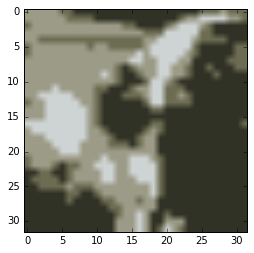

In [534]:
import matplotlib.pyplot as plt
plt.imshow(k_coloured_images_shaped[5007])
plt.show()

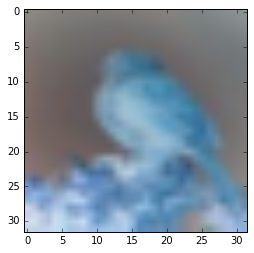

In [543]:
plt.imshow(x_full[5008])
plt.show()

In [469]:
pixel_labels_shaped = np.reshape(pixel_labels, (6000,1024))

In [470]:
from keras.utils import np_utils
newLabels = np_utils.to_categorical(pixel_labels_shaped)

In [471]:
newLabels.shape

(6000, 1024, 4)

In [472]:
newLabels_shaped = np.reshape(newLabels, (6000,4096))

In [473]:
newLabels_shaped.shape

(6000, 4096)

In [474]:
print(pixel_labels_shaped[0])
print(newLabels_shaped[0])

[2 0 0 ..., 0 0 0]
[ 0.  0.  1. ...,  0.  0.  0.]


In [475]:
from skimage.color import rgb2gray

In [476]:
x_gray_full = rgb2gray(x_full)

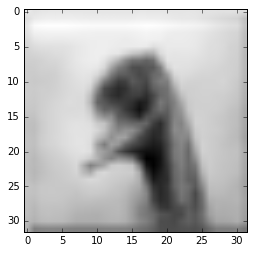

In [552]:
plt.imshow(x_gray_full[5006],cmap='gray')
plt.show()

In [545]:
x_gray_full = np.reshape(x_gray_full, (6000,32,32,1))

In [480]:
x_gray_full.shape

(6000, 32, 32, 1)

In [513]:
X_train = x_gray_full[:5000]
X_test = x_gray_full[5000:6000]
y_train = newLabels[:5000]
y_test = newLabels[5000:6000]

In [515]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Reshape, Activation
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4096))
model.add(Dropout(0.2))
model.add(Dense(4096))
model.add(Dropout(0.2))
model.add(Reshape((1024, 4)))
model.add(Activation('softmax'))
model.compile(optimizer="adam",loss="categorical_crossentropy")

In [516]:
from keras.callbacks import ModelCheckpoint,Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        print('\nTesting loss: {}\n'.format(loss))
        
    def return_test(self):
        return self.test_loss

test_callback = TestCallback((X_test, y_test))
filepath="weights.bestCNN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, test_callback]

In [557]:
history = model.fit(X_train, y_train,validation_split=0.33,batch_size=1000,callbacks = callbacks_list,epochs=5,verbose=1)

Train on 3349 samples, validate on 1651 samples
Epoch 1/5
3349/3349 [==============================] - 20s 6ms/step - loss: 1.3131 - val_loss: 1.3028

Epoch 00001: val_loss improved from 1.30714 to 1.30282, saving model to weights.bestCNN.hdf5

Testing loss: 1.3111621341705322

Epoch 2/5
3349/3349 [==============================] - 17s 5ms/step - loss: 1.3060 - val_loss: 1.3009

Epoch 00002: val_loss improved from 1.30282 to 1.30085, saving model to weights.bestCNN.hdf5

Testing loss: 1.3088614463806152

Epoch 3/5
3349/3349 [==============================] - 17s 5ms/step - loss: 1.3009 - val_loss: 1.2917

Epoch 00003: val_loss improved from 1.30085 to 1.29174, saving model to weights.bestCNN.hdf5

Testing loss: 1.298697934150696

Epoch 4/5
3349/3349 [==============================] - 17s 5ms/step - loss: 1.2963 - val_loss: 1.2931

Epoch 00004: val_loss did not improve

Testing loss: 1.3002438745498657

Epoch 5/5
3349/3349 [==============================] - 17s 5ms/step - loss: 1.2906 -

--------------------------Test image number :  0 ----------------------------
Predicted Image 4-coloured
1024


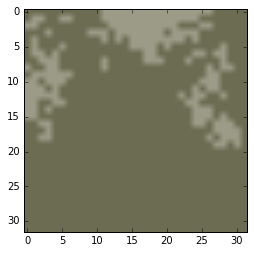

K-means Image 4-coloured


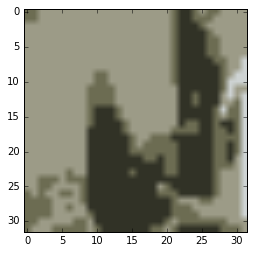

Input Grayscale


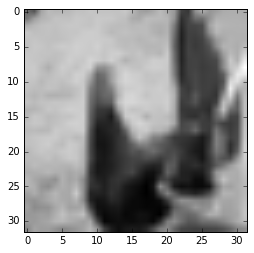

--------------------------Test image number :  1 ----------------------------
Predicted Image 4-coloured
1024


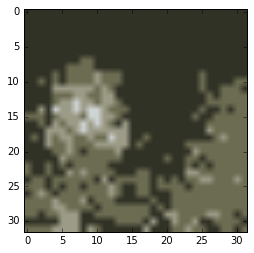

K-means Image 4-coloured


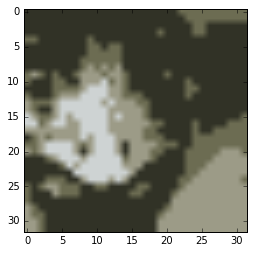

Input Grayscale


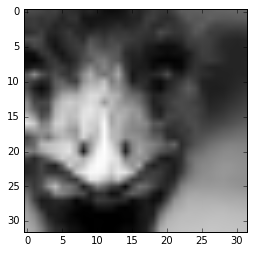

--------------------------Test image number :  2 ----------------------------
Predicted Image 4-coloured
1024


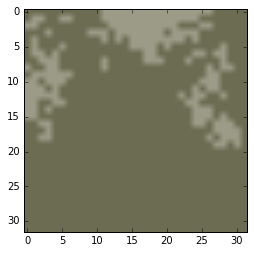

K-means Image 4-coloured


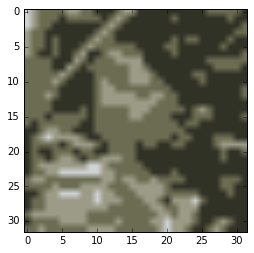

Input Grayscale


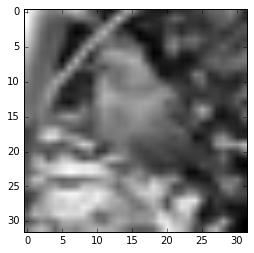

--------------------------Test image number :  3 ----------------------------
Predicted Image 4-coloured
1024


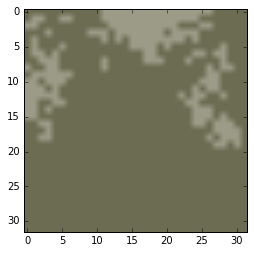

K-means Image 4-coloured


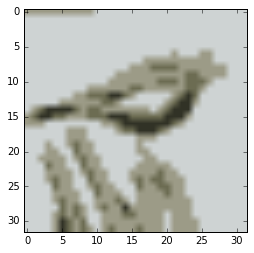

Input Grayscale


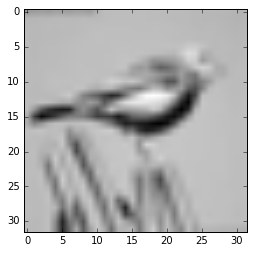

--------------------------Test image number :  4 ----------------------------
Predicted Image 4-coloured
1024


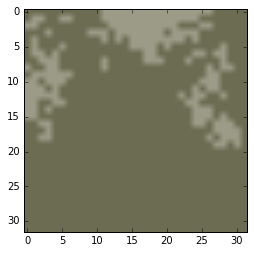

K-means Image 4-coloured


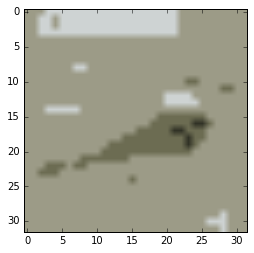

Input Grayscale


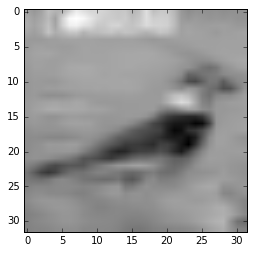

--------------------------Test image number :  5 ----------------------------
Predicted Image 4-coloured
1024


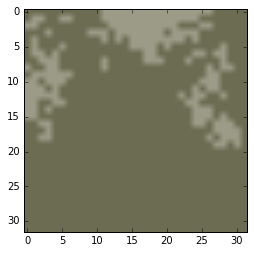

K-means Image 4-coloured


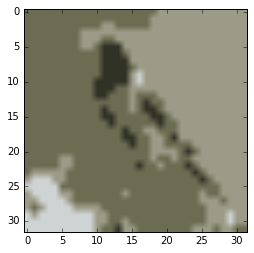

Input Grayscale


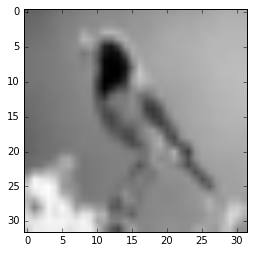

--------------------------Test image number :  6 ----------------------------
Predicted Image 4-coloured
1024


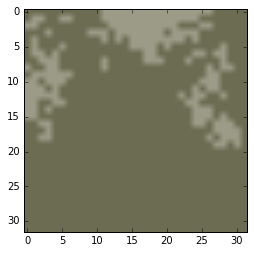

K-means Image 4-coloured


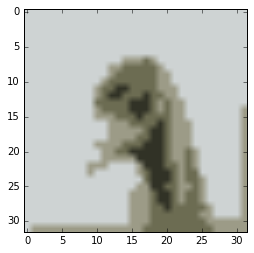

Input Grayscale


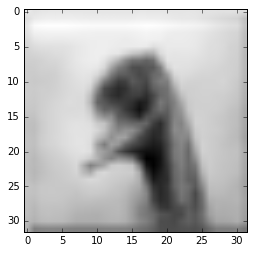

--------------------------Test image number :  7 ----------------------------
Predicted Image 4-coloured
1024


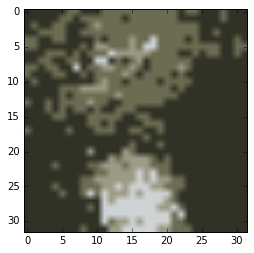

K-means Image 4-coloured


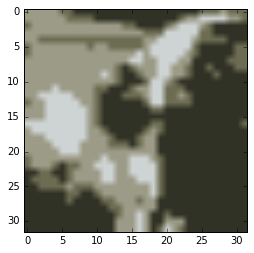

Input Grayscale


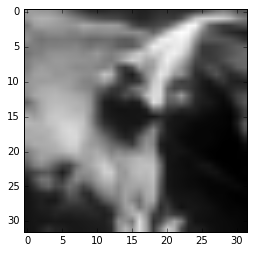

--------------------------Test image number :  8 ----------------------------
Predicted Image 4-coloured
1024


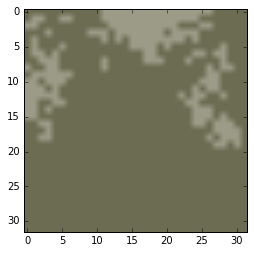

K-means Image 4-coloured


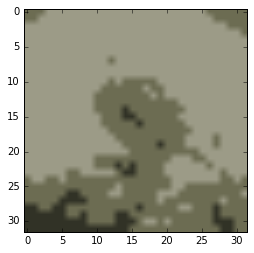

Input Grayscale


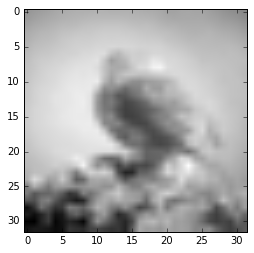

--------------------------Test image number :  9 ----------------------------
Predicted Image 4-coloured
1024


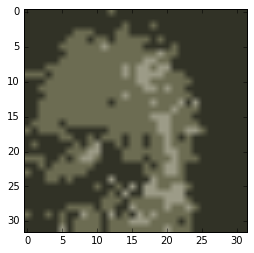

K-means Image 4-coloured


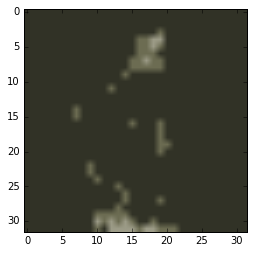

Input Grayscale


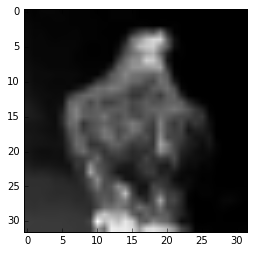

In [561]:
for i in range(10):
    print("--------------------------Test image number : ",i,"----------------------------")
    print("Predicted Image 4-coloured")
    predicted = model.predict(X_test[i:i+1])
    predicted = np.reshape(predicted,(1024,4))
    predicted_labels = np.argmax(predicted,axis = 1)
    print(len(predicted_labels))
    k_coloured_predicted = []
    for k in predicted_labels:
        k_coloured_predicted.append(np.uint8(kmeans.cluster_centers_[k]))
    k_coloured_predicted_shaped = np.reshape(k_coloured_predicted,(32,32,3))
    plt.imshow(k_coloured_predicted_shaped)
    plt.show()
    print("K-means Image 4-coloured")
    plt.imshow(k_coloured_images_shaped[5000+i])
    plt.show()
    print("Input Grayscale")
    plt.imshow(np.reshape(X_test[i:i+1],(32,32)),cmap='gray')
    plt.show()

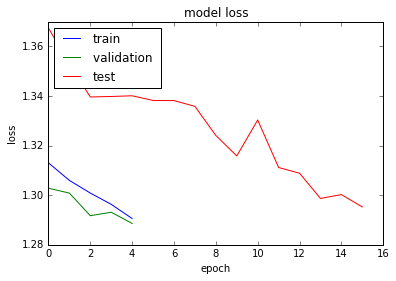

In [560]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(test_callback.return_test())
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation ','test'], loc='upper left')
plt.show()